### impute weather data

objective: `comparison of linear and spline imputation` with `univariant LSTM-based multi-step forecasting` to decide how to impute missing value in 2023

1. chose sufficiently long sequence of weather data from previous years (without any missing data) as training and test data for different imputation methods
2. construct samples with X sequential timestamps for training RNN
3. construct evaluation pipeline to compare performance + plot
4. chose best performing method (per feature) and train on data of previous year and impute missing data in 2023


In [4]:
import pandas as pd

df_weather_train = pd.read_csv('datasets/df_meteorological_train_data.csv')
df_weather_val = pd.read_csv('datasets/df_meteorological_val_data.csv')

### LSTM

In [40]:
# evalutation
from sklearn.metrics import mean_absolute_error
import numpy as np

def evaluate_forecasts(true, predicted):
    scores = []
    for i in range(len(true[0])):
            mae = mean_absolute_error(np.array(true)[:, i] , np.array(predicted)[:, i])
            scores.append(mae)
    
    score = round(sum(scores)/ len(scores),2)
    return scores, score

def plot_r2_forecast(scores1, scores2, scores3,scores4, score1, score2, score3, score4, name, name1, name2, name3, name4, row, col, axs):
    timesteps =[x for x in range(1,len(scores1)+1)]
    axs[row, col].plot(timesteps, scores1, marker='o', label = (f'{name1}: {score1}'))
    axs[row, col].plot(timesteps, scores2, marker='o', label = (f'{name2}: {score2}'), color = 'cyan')
    axs[row, col].plot(timesteps, scores3, marker='o', label = (f'{name3}: {score3}'), color = 'magenta')
    axs[row, col].plot(timesteps, scores4, marker='o', label = (f'{name4}: {score4}'), color = 'green')
    axs[row, col].set_title(f'MAE Score {name}')
    axs[row, col].set_ylabel('MAE Score')
    axs[row, col].set_xlabel('Forecasting Timesteps')
    axs[row, col].legend()


def impute_linear(current_data, feature):
    current = current_data.copy()
    current[24:-12] = None # replace middle values with none
    current = current.interpolate(method= 'linear') # interpolate values
    return current[24:-12][feature].tolist()

def impute_spline(current_data, feature):
    current = current_data.copy()
    current[24:-12] = None # replace middle values with none
    current = current.interpolate(method= 'spline', order = 3) # interpolate values
    return current[24:-12][feature].tolist()

def impute_lstm(current_data, model, timesteps):
    
    input_data = np.array(current_data[:24], dtype= 'float')
    input_data = input_data.reshape(1, timesteps, 1)
    predicted = (model.predict(input_data, verbose=0).tolist()[0])
    return predicted

def impute_cnn_lstm(current_data, model, timesteps):
    
    input_data = np.array(current_data[:24], dtype= 'float')
    input_data = input_data.reshape(1, timesteps, 1)
    predicted = (model.predict(input_data, verbose=0).tolist()[0])
    return predicted



train.shape = (454, 24, 1)
finish training lstm for prec_mm
train.shape = (454, 24, 1)
finish training cnn-lstm for prec_mm
train.shape = (454, 24, 1)
finish training lstm for humidity
train.shape = (454, 24, 1)
finish training cnn-lstm for humidity
train.shape = (454, 24, 1)
finish training lstm for temp
train.shape = (454, 24, 1)
finish training cnn-lstm for temp
train.shape = (454, 24, 1)
finish training lstm for sun_min
train.shape = (454, 24, 1)
finish training cnn-lstm for sun_min
train.shape = (454, 24, 1)
finish training lstm for wind_speed
train.shape = (454, 24, 1)
finish training cnn-lstm for wind_speed
train.shape = (454, 24, 1)
finish training lstm for air_pressure
train.shape = (454, 24, 1)
finish training cnn-lstm for air_pressure


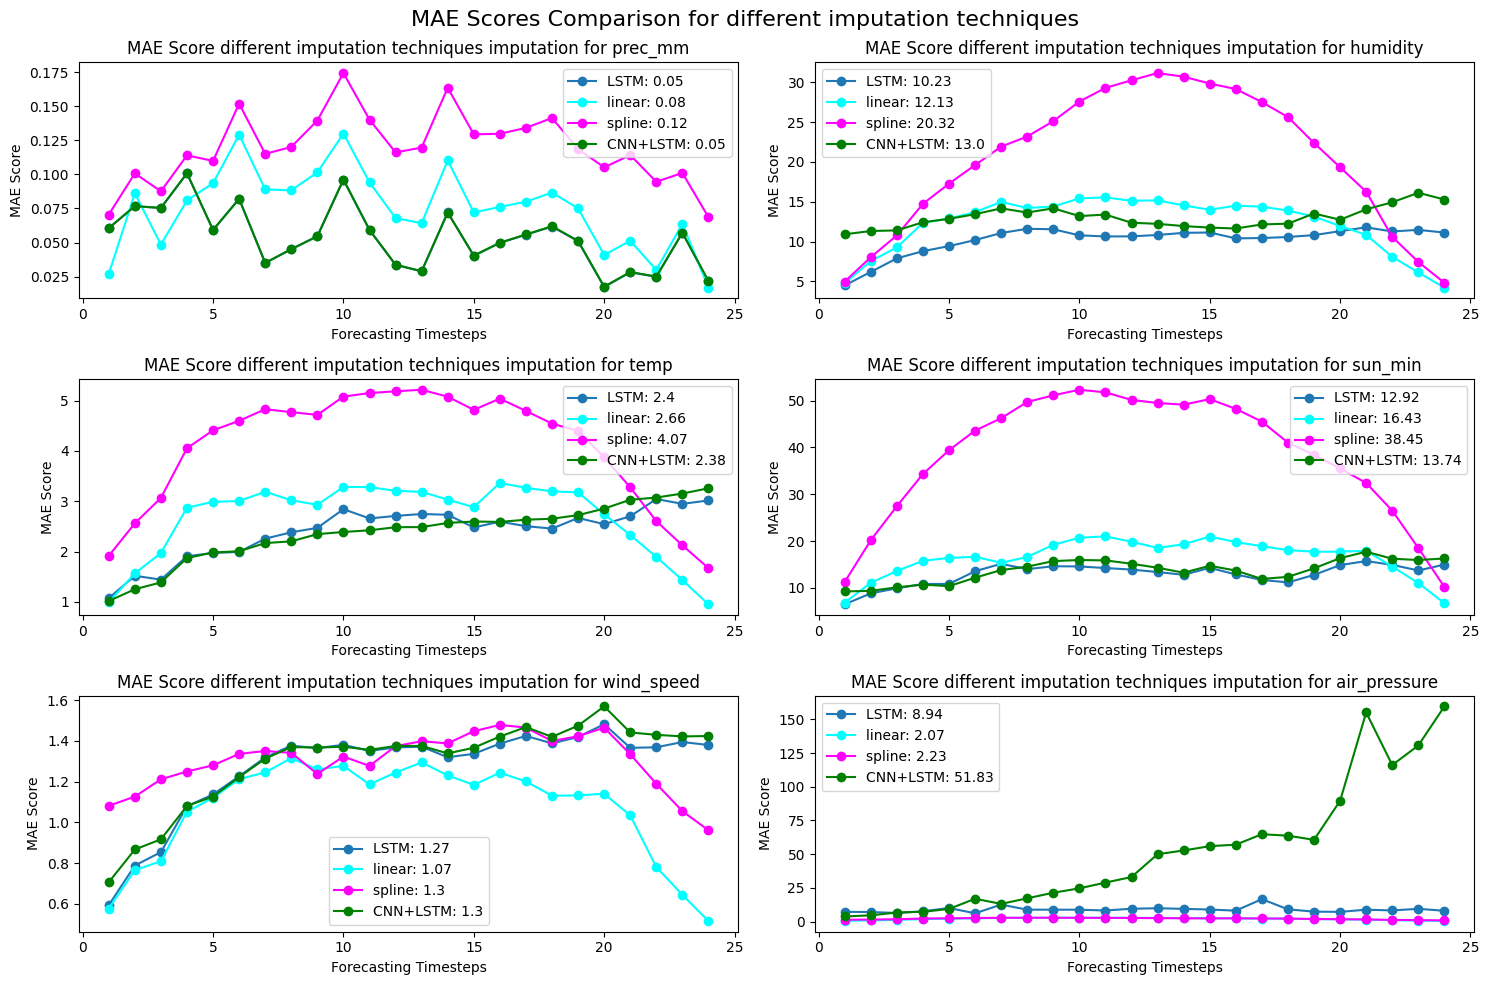

In [107]:
# evalutation
from utilities.LSTM_model import LSTM_model
import matplotlib.pyplot as plt
import numpy as np


timesteps = 24
method_name = 'different imputation techniques'
interval = [x for x in range(0, 8941, 60)]
features = ['prec_mm', 'humidity', 'temp', 'sun_min', 'wind_speed', 'air_pressure']

#  initialize plot
fig, axs = plt.subplots(3, 2, figsize=(15, 10))
fig.suptitle(f'MAE Scores Comparison for {method_name}', fontsize=16)
fig.subplots_adjust(top=0.9)

for n in range(len(features)):
    
    feature = features[n]

    row = n // 2  # parameters for plotting
    col = n % 2  # parameters for plotting
    
    
    true = []
    predicted_lstm = []
    predicted_linear = []
    predicted_spline = []
    predicted_cnn_lstm = []
    
    model_lstm = LSTM_model(df = df_weather_train, timesteps= 24, epochs= 5, batch_size= 32).train_uni_LSTM(feature= feature)
    model_cnn_lstm = LSTM_model(df = df_weather_train, timesteps= 24, epochs= 5, batch_size= 32).train_uni_CNN_LSTM(feature= feature)
    for n in range(1, len(interval)):
        
        current = df_weather_val[interval[n-1]:interval[n]].reset_index().filter([feature]) # select 48 instances
        true.append((current[24:-12].copy()[feature].tolist())) # save true values
        
        predicted_lstm.append(impute_lstm(current_data = current, model = model_lstm, timesteps = timesteps))
        predicted_linear.append(impute_linear(current_data = current, feature = feature))
        predicted_spline.append(impute_spline(current_data = current, feature = feature))
        predicted_cnn_lstm.append(impute_lstm(current_data = current, model = model_cnn_lstm, timesteps = timesteps))
    
    scores1, score1 = evaluate_forecasts(true= true, predicted= predicted_lstm)
    scores2, score2 = evaluate_forecasts(true= true, predicted= predicted_linear)
    scores3, score3 = evaluate_forecasts(true= true, predicted= predicted_spline)
    scores4, score4 = evaluate_forecasts(true= true, predicted= predicted_cnn_lstm)

    plot_r2_forecast(scores1= scores1, scores2= scores2, scores3= scores3, scores4= scores4,
                     score1 = score1, score2 = score2, score3 = score3,score4= score4,
                     name1 = 'LSTM', name2 = 'linear', name3 ='spline',name4 ='CNN+LSTM',
                     name = f'{method_name} imputation for {feature}',
                     row= row, col= col , axs= axs)

fig.tight_layout()

plt.savefig(f"data/weather/hourly/output/MAE_Imputation_{method_name.replace(' ','_')}_2.png", dpi = 180)
plt.show()

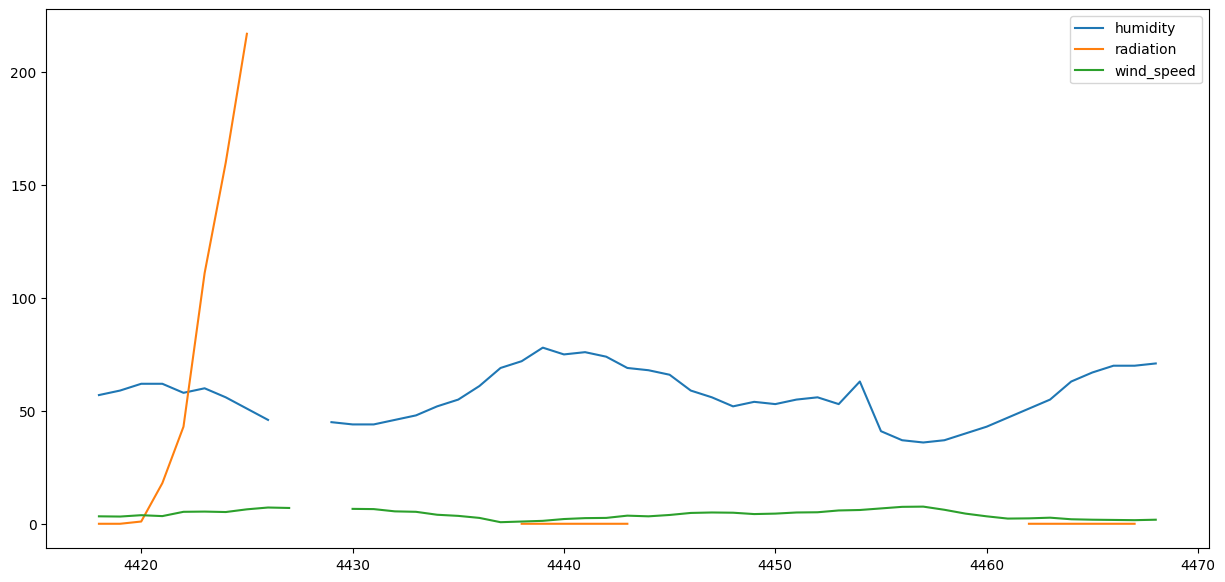

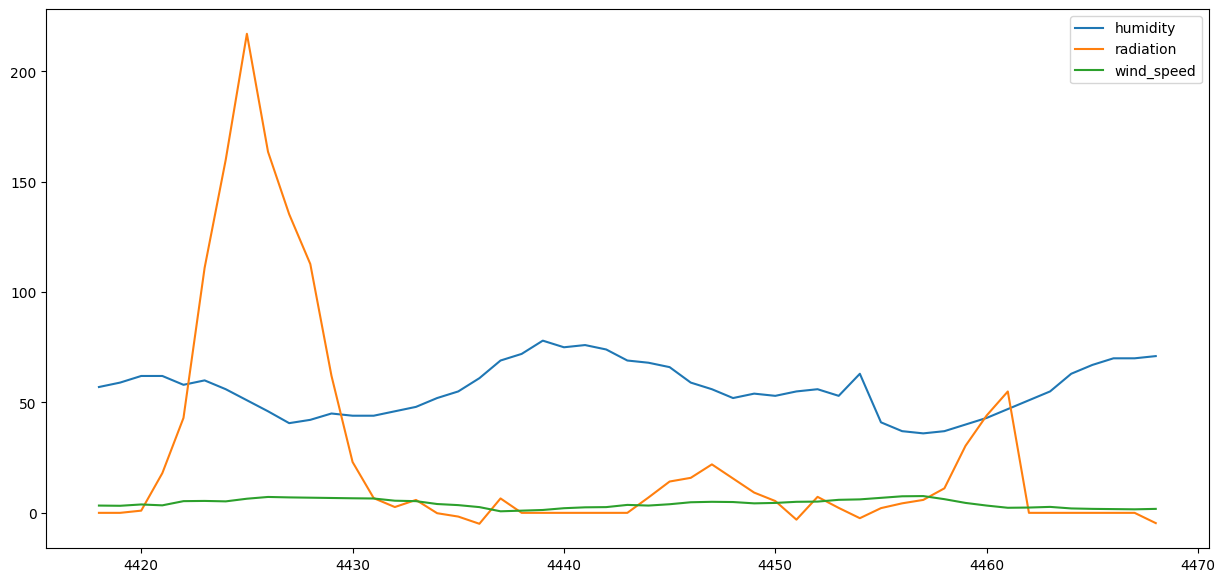

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

df_meteo_na = pd.read_csv('datasets/df_meteorological_na.csv')
df_meteo_imput = pd.read_csv('datasets/df_meteorological_impute.csv')

start_date = 2023070401
end_date = 2023070605

example_missing = df_meteo_na[(df_meteo_na['time_step'] > start_date) & (df_meteo_na['time_step'] < end_date)]

example_missing_imputed= df_meteo_imput[(df_meteo_imput['time_step'] > start_date) & (df_meteo_imput['time_step'] < end_date)]

plt.figure(figsize=(15, 7)) 
plt.plot(example_missing[['humidity', 'radiation', 'wind_speed']], label = ['humidity', 'radiation', 'wind_speed'])
plt.legend()
plt.show()
plt.figure(figsize=(15, 7)) 
plt.plot(example_missing_imputed[['humidity', 'radiation',  'wind_speed']], label = ['humidity', 'radiation',  'wind_speed'])
plt.legend()
plt.show()